# Step 4. Detecting Sperm Body
- Goal: to further remove outlier pixels from the foreground object obtained in the preceding step, and to split the body into head and flagellum.
- Challenge: the length of the flagellum detected in the preceding step varies frame by frame.

In [1]:
from __future__ import print_function
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from Step4Helpers import *

In [2]:
def DisplayImageAsArray(image, title):
    array = sitk.GetArrayFromImage(image)
    plt.imshow(array, cmap='gray')
    plt.title(title)
    plt.show()
    return

In [3]:
def DisplayArrayWith2Columns(array, xmax, ymax, title):
    plt.plot(array[:,1], array[:,0], ".")
    x1,x2,y1,y2 = plt.axis()
    plt.axis((0,xmax,0,ymax))
    plt.title(title)
    plt.show()
    return

In [4]:
def Display2ArraysWith2Columns(array1, array2, xmax, ymax,
                               label1, label2, title):
    plt.plot(array1[:,1], array1[:,0], "g.", label=label1)
    plt.plot(array2[:,1], array2[:,0], "b.", label=label2)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((0,xmax,0,ymax))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.title(title)
    plt.show()
    return

## 4.1 Read the movie.

In [5]:
imread = sitk.ImageFileReader()
imread.SetFileName( '../Movie/movieThresholding.mha' )
movie = imread.Execute();
# Recall: parameters for Thresholding:
# - nbhd = 2
# - threshold = 10

In [6]:
# Get the size of the movie.
(n1,n2,n3) = movie.GetSize()

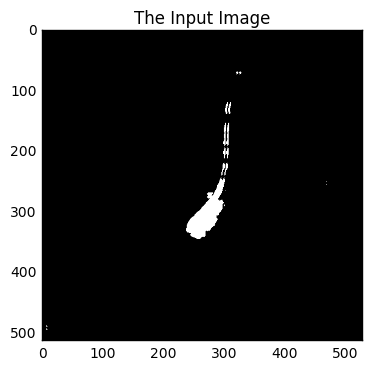

In [7]:
# Disply a frame as an example.
I = movie[:,:,0]
DisplayImageAsArray(I, "The Input Image")

## 4.2 Remove outlier pixels of a frame.
Note: pixel (i,j) in an image corresponds to element (j,i) in the array.

Size of each array in this section:
- pixels_raw = 2-column np.array in (y,x) pairs
- body = 2-column np.array in (y,x) pairs

In [8]:
def CleanImage( image, threshold ):
    # Convert the image to an array.
    A = np.array( sitk.GetArrayFromImage( image ) )
    # Find the indicies (i,j) such that A[i,j] = 1.
    row,col = np.where( A == 1 )
    # pixels_raw = list of (i,j) such that A[i,j] = 1.
    pixels_raw = np.array([row,col]).transpose()
    # pixels_clean = pixels_raw - outliers
    pixels_clean = RemoveOutliers2D( pixels_raw, threshold )
    return pixels_raw, pixels_clean

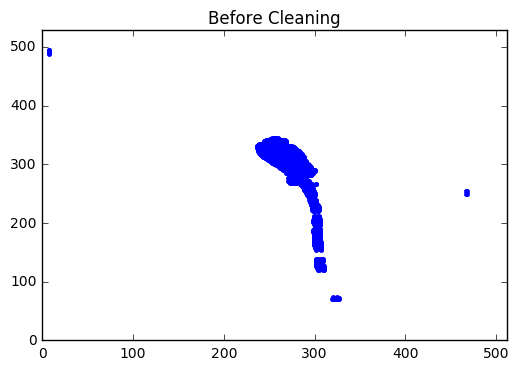

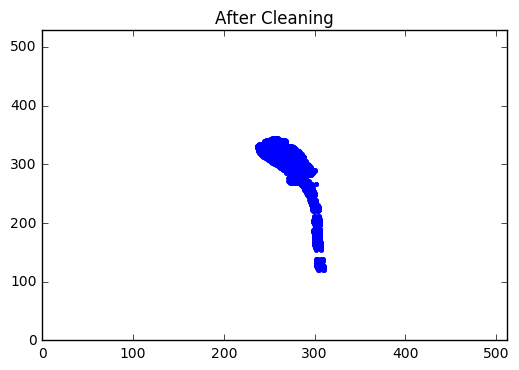

In [9]:
# pixels_raw = all foreground pixels
# body = all foreground pixels - outlier pixels ~ body pixels
pixels_raw, body = CleanImage( I, 3 )
DisplayArrayWith2Columns(pixels_raw, n2, n1, "Before Cleaning")
DisplayArrayWith2Columns(body, n2, n1, "After Cleaning")

## 4.2 Determine horizontality.
Idea:
- If the sperm is swimming horizontally, then there are more unique x values than unique y values.
- If the sperm is swimming vertically, then there are more unique y values than unique x values.

Size of each array in this section:
- body = 2-column np.array in (y,x) pairs
- lowercurve = 2-column np.array in (y,x) pairs
- uppercurve = 2-column np.array in (y,x) pairs

In [10]:
# Count the unique values in x-axis and y-axis, respectively.
xnum = len( np.unique( body[:,1] ) )
ynum = len( np.unique( body[:,0] ) )

In [11]:
if xnum>=ynum:
    # The sperm is swimming horizontally.
    horizontality = 1
    # Sort the array such that the 2nd column is ascending.
    body = body[ np.argsort( body[:, 1] ) ]
    # Compute the lower and upper curves.
    lowercurve = SimplifyX(body,1)
    uppercurve = SimplifyX(body,0)
else:
    # The sperm is swimming vertically.
    horizontality = 0
    # Sort the array such that the 1st column is ascending.
    body = body[ np.argsort( body[:, 0] ) ]
    # Compute the lower and upper curves.
    lowercurve = SimplifyY(body,1)
    uppercurve = SimplifyY(body,0)

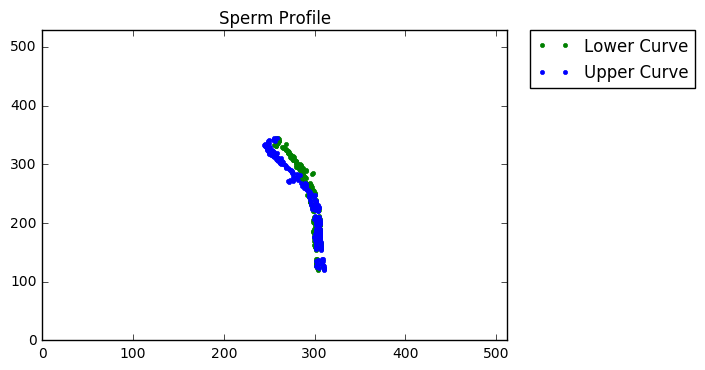

In [12]:
Display2ArraysWith2Columns(lowercurve, uppercurve, n2, n1, 
                          "Lower Curve", "Upper Curve", "Sperm Profile")

## 4.3 Determine the head and the flagellum.
Idea:
- The head is wider than the flagellum.
- The head can be considered symmetric in the same way as an ellipse.

Notation:
- Let $x_{min}$ be the minimum x value among all pixels that form the sperm body.
- Define $x_{max}$, $y_{min}$, $y_{max}$ in a similar way.

Algorithm:
- Without loss of generality, assume that the sperm is swimming horizontally.
- Compute the longest line segment across the body in the vertical direction. 
- Say that the longest line lies on the line $x = x^*$. Then $x^*$ is the $x$-component of the center of gravity of the head.
- Then based on the location of $x^*$ in the range $[x_{min}, x_{max}]$, determine whether the sperm is swimming to the left or to the right.
- Without loss of generality, assume that the sperm is swimming to the left. 
- The left end point of the head is xmin, and the center is $x^*$. So if the head is symmeteric, the right end point of the head is $x^*+(x^*-x_{min})$.

Disadvantage:
- This algorithm relies on the fact that a decent amount of flagellum is segmented.
- This algorithm also requires that no outliers in the set of pixels.
- This algorithm uses too many if loops.

Size of each array in this section:
- head = 2-column np.array in (y,x) pairs
- tail = 2-column np.array in (y,x) pairs

In [13]:
# Maximum width of the head is set to be maxheadwidth pixels.
maxheadwidth = 80
# If the ratio of head length to body length exceeds 2*headbodyratio,
# the frame is considered as a valid frame, 
# If not, no further calculations using the information of this frame.
headbodyratio = 3.0/10
# Determine the outliers in head and move them to the flagellum.
# The threshold value which determines outliers is given by outliercriterion
outliercriterion = 135

In [14]:
if xnum>=ynum:
    # Make (x,y) pairs.
    lowercurve1 = np.fliplr(lowercurve)
    uppercurve1 = np.fliplr(uppercurve)
    body1 = np.fliplr(body)
    goodframe, data, head = GoodFrameTest(lowercurve1,uppercurve1,body1,
                                          maxheadwidth,headbodyratio)
else:
    lowcurve = np.fliplr(lowercurve)
    uppcurve = np.fliplr(uppercurve)
    goodframe, data, head = GoodFrameTest(lowercurve,uppercurve,body,
                                          maxheadwidth,headbodyratio)

In [15]:
if goodframe:
    print( "This is a good frame, we will continue the calcucation." )
else:
    print( "Choose another frame to work with." )

Choose another frame to work with.


In [16]:
if xnum>=ynum:
    head1, tail1, orientation = SeparateHeadTail(lowercurve1,uppercurve1,
                                         body1,data,head,
                                         outliercriterion)
    # Make (y,x) pairs.
    head = np.fliplr(head1)
    tail = np.fliplr(tail1)
else:
    head, tail, orientation = SeparateHeadTail(lowercurve,uppercurve,
                                       body,data,head,
                                       outliercriterion)

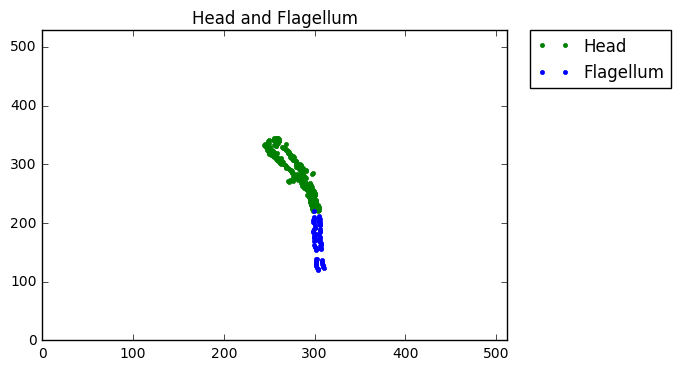

In [17]:
Display2ArraysWith2Columns(head, tail, n2, n1,
                           "Head", "Flagellum", "Head and Flagellum")

In [18]:
if horizontality:
    if orientation:
        print( "The sperm is swimming leftward." )
    else:
        print( "The sperm is swimming rightward." )
else:
    if orientation:
        print( "The sperm is swimming downward." )
    else:
        print( "The sperm is swimming upward." )

The sperm is swimming upward.


## 4.4 Use another frame to make a second example.

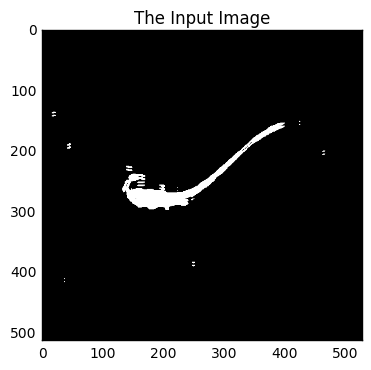

In [19]:
# Disply a frame as an example.
I = movie[:,:,19]
DisplayImageAsArray(I, "The Input Image")

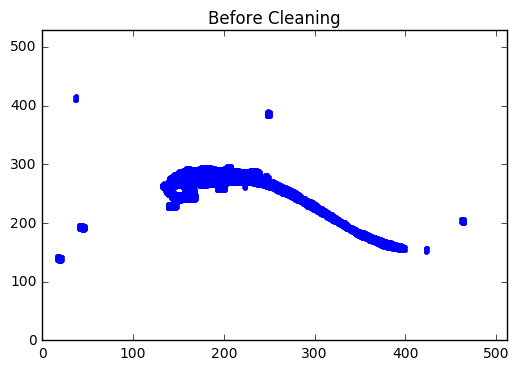

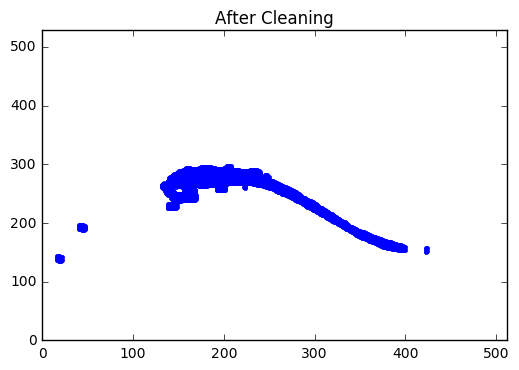

In [20]:
# pixels_raw = all foreground pixels
# body = all foreground pixels - outlier pixels ~ body pixels
pixels_raw, body = CleanImage( I, 3 )
DisplayArrayWith2Columns(pixels_raw, n2, n1, "Before Cleaning")
DisplayArrayWith2Columns(body, n2, n1, "After Cleaning")

In [21]:
# Count the unique values in x-axis and y-axis, respectively.
xnum = len( np.unique( body[:,1] ) )
ynum = len( np.unique( body[:,0] ) )

In [22]:
if xnum>=ynum:
    # The sperm is swimming horizontally.
    horizontality = 1
    # Sort the array such that the 2nd column is ascending.
    body = body[ np.argsort( body[:, 1] ) ]
    # Compute the lower and upper curves.
    lowercurve = SimplifyX(body,1)
    uppercurve = SimplifyX(body,0)
else:
    # The sperm is swimming vertically.
    horizontality = 0
    # Sort the array such that the 1st column is ascending.
    body = body[ np.argsort( body[:, 0] ) ]
    # Compute the lower and upper curves.
    lowercurve = SimplifyY(body,1)
    uppercurve = SimplifyY(body,0)

In [23]:
if xnum>=ynum:
    # Make (x,y) pairs.
    lowercurve1 = np.fliplr(lowercurve)
    uppercurve1 = np.fliplr(uppercurve)
    body1 = np.fliplr(body)
    goodframe, data, head = GoodFrameTest(lowercurve1,uppercurve1,body1,
                                          maxheadwidth,headbodyratio)
else:
    lowcurve = np.fliplr(lowercurve)
    uppcurve = np.fliplr(uppercurve)
    goodframe, data, head = GoodFrameTest(lowercurve,uppercurve,body,
                                          maxheadwidth,headbodyratio)

In [24]:
if goodframe:
    print( "This is a good frame, we will continue the calcucation." )
else:
    print( "Choose another frame to work with." )

This is a good frame, we will continue the calcucation.


In [25]:
if xnum>=ynum:
    head1, tail1, orientation = SeparateHeadTail(lowercurve1,uppercurve1,
                                         body1,data,head,
                                         outliercriterion)
    # Make (y,x) pairs.
    head = np.fliplr(head1)
    tail = np.fliplr(tail1)
else:
    head, tail, orientation = SeparateHeadTail(lowercurve,uppercurve,
                                       body,data,head,
                                       outliercriterion)

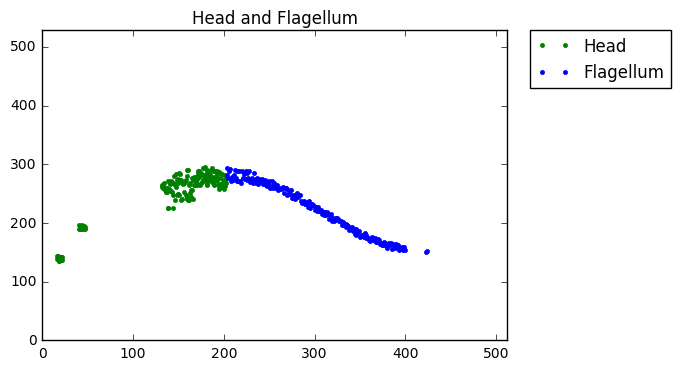

In [26]:
Display2ArraysWith2Columns(head, tail, n2, n1,
                           "Head", "Flagellum", "Head and Flagellum")

In [27]:
if horizontality:
    if orientation:
        print( "The sperm is swimming leftward." )
    else:
        print( "The sperm is swimming rightward." )
else:
    if orientation:
        print( "The sperm is swimming downward." )
    else:
        print( "The sperm is swimming upward." )

The sperm is swimming leftward.
